# Portfolio and Benchmark setup

This notebook demonstrates the creation of portfolios & public indices reconstruction as benchmark and then backtesting them together.

### Overview

This notebook covers:
- Creation of arbitrary portfolio of so called Magnificent 8 tech stocks and their daily positional holdings
- Reconstruction of Nasdaq 100 index and its daily positional holdings
- Creation of portfolio that contains Invesco QQQ ETF, so as to ensure that we have correctly reconstructed the Nasdaq 100 index
- Back test all three portfolios together with market weighted & equal weighted approach

### Prerequisites

Before running this notebook, ensure you have:
- Required Python packages installed
- Database credentials stored in keyring
- Appropriate database schema and functions
- ipython-sql to run sql in the notebook

## 1. Environment Setup and Path Configuration

Set up the Python environment by configuring import paths and ensuring juypyter notebook can access custom modules in the project structure.

In [1]:
import sys
import os

import pandas as pd

# Get the current notebook's directory and go up to parent
current_dir = os.getcwd()
parent_dir = os.path.dirname(os.path.dirname(current_dir))

if parent_dir not in sys.path:
    sys.path.append(parent_dir)

print(f"Current directory: {current_dir}")
print(f"Added to path: {parent_dir}")
data_eng_path = os.path.join(parent_dir, 'data_engineering')
files_path = os.path.join(parent_dir, 'toolkit\\files')
print(f"Data engineering folder exists: {os.path.exists(data_eng_path)}")
print(f"Files folder exists: {os.path.exists(files_path)}")

Current directory: c:\Users\menon\OneDrive\Documents\SourceCode\InvestmentManagement\toolkit\notebooks
Added to path: c:\Users\menon\OneDrive\Documents\SourceCode\InvestmentManagement
Data engineering folder exists: True
Files folder exists: True


## 2. Database Connection and Module Imports

Establish database connectivity and import required modules for data engineering and market data retrieval.<br> 
It includes retry logic for database connection failures and sets up SQL magic commands for inline SQL execution.


In [2]:

from data_engineering.database import db_functions as database
from data_engineering.eod_data import yahoo_functions as yahoo

engine, connection,conn_str, session = database.get_db_connection()
# --- Load ipython-sql magic (requires ipython-sql to be installed) ---
%load_ext sql

# --- Connect to SQL Server ---
%sql $conn_str

%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

Database connection successful.


## 3. Backtest Period Definition

Setting the analysis period for the backtest. These dates define the time window for all portfolio performance calculations and risk metrics.

In [3]:
start_date = "2025-01-02"
end_date = "2025-06-06"

## 4. Portfolio Creation - Magnificent 8 Tech Stocks

Creating the first portfolio containing concentrated positions in the "Magnificent 8" technology stocks.

In [4]:
result = %sql INSERT INTO [dbo].[portfolio] (portfolio_short_name, portfolio_name, portfolio_type, is_active) \
         OUTPUT INSERTED.port_id \
         VALUES ('MAG8', 'Backtest Mag 8', 'Portfolio', 1);

new_port_id = result[0][0]

Confirming the Magnificent 8 portfolio was successfully created in the database.

In [5]:
%%sql
SELECT * FROM [dbo].[portfolio] WHERE port_id = :new_port_id

port_id,portfolio_short_name,portfolio_name,portfolio_type,is_active
1,MAG8,Backtest Mag 8,Portfolio,1


##### Generate Holdings History for Magnificent 8 Portfolio
Create daily position & holding units for the Magnificent 8 stocks across all business days in the backtest period.<br>
Store the data in portfolio_holdings table<br> 
Verify that the data has been succesfully stored

In [6]:
%%sql
;WITH securities AS (
    SELECT   security_id,symbol
    FROM    dbo.security_master
    WHERE   symbol in ('MSFT','NVDA','TSLA','AMZN','AAPL','AVGO','GOOG','META')
),
dates AS (
    SELECT CAST(:start_date AS DATE) dt
    UNION ALL
    SELECT DATEADD(DAY, 1, dt) FROM dates WHERE dt < :end_date
),
business_dates AS (
    SELECT dt FROM dates WHERE DATEPART(WEEKDAY, dt) BETWEEN 2 AND 6
),
share_quantities AS (
    SELECT    security_id
            , symbol,
               CASE symbol
                   WHEN 'MSFT' THEN 5
                   WHEN 'GOOG' THEN 4
                   WHEN 'AVGO' THEN 3
                   WHEN 'META' THEN 2
                   ELSE 1
               END AS shares
    FROM    securities
)
INSERT INTO dbo.portfolio_holdings(as_of_date, port_id, security_id, held_shares, upsert_date, upsert_by)
SELECT      bd.dt
           ,:new_port_id
           ,sq.security_id
           ,sq.shares AS held_shares
           ,GETDATE() AS upsert_date
           ,SYSTEM_USER AS upsert_by
FROM        business_dates bd
CROSS JOIN  share_quantities sq
ORDER BY    bd.dt, sq.symbol
OPTION (MAXRECURSION 32767);

----------------------------------------------------------------------------------------
SELECT TOP 10 sm.symbol,ph.*
FROM		dbo.portfolio_holdings ph
INNER JOIN	dbo.security_master sm
			ON  ph.security_id = sm.security_id
WHERE		port_id = :new_port_id
ORDER BY	as_of_date


symbol,ph_id,as_of_date,port_id,security_id,held_shares,upsert_date,upsert_by
AAPL,1,2025-01-02,1,25523,1.0000,2025-09-14 14:23:43.930000,dbomanager
AMZN,2,2025-01-02,1,29464,1.0000,2025-09-14 14:23:43.930000,dbomanager
AVGO,3,2025-01-02,1,39206,3.0000,2025-09-14 14:23:43.930000,dbomanager
GOOG,4,2025-01-02,1,71972,4.0000,2025-09-14 14:23:43.930000,dbomanager
META,5,2025-01-02,1,94947,2.0000,2025-09-14 14:23:43.930000,dbomanager
MSFT,6,2025-01-02,1,98618,5.0000,2025-09-14 14:23:43.930000,dbomanager
NVDA,7,2025-01-02,1,105793,1.0000,2025-09-14 14:23:43.930000,dbomanager
TSLA,8,2025-01-02,1,132332,1.0000,2025-09-14 14:23:43.930000,dbomanager
AAPL,9,2025-01-03,1,25523,1.0000,2025-09-14 14:23:43.930000,dbomanager
AMZN,10,2025-01-03,1,29464,1.0000,2025-09-14 14:23:43.930000,dbomanager


## 5. Nasdaq 100 Index - Reconstruction

Fetch current Nasdaq 100 constituents using Financial Modeling Prep API.<br>
This provides the universe of securities for reconstructing the Nasdaq 100 index.


In [7]:
import datetime as dt
import json
import ssl
from urllib.request import urlopen

import certifi
import keyring
import pandas as pd

def get_jsonparsed_data(url):
    # Create SSL context instead of using deprecated cafile parameter
    context = ssl.create_default_context(cafile=certifi.where())
    response = urlopen(url, context=context)
    data = response.read().decode("utf-8")
    return json.loads(data)

url = ("https://financialmodelingprep.com/api/v3/nasdaq_constituent?apikey=eaa83187bd18f51cf2c84830f00e89ae")
df_nasdaq = pd.DataFrame(get_jsonparsed_data(url))[['symbol','name','sector','subSector']]
df_nasdaq = df_nasdaq.rename(columns={'name': 'security_name'})
df_nasdaq

,symbol,security_name,sector,subSector
0,ADBE,Adobe Inc.,Technology,Software - Infrastructure
1,AMAT,Applied Materials,Technology,Semiconductors
2,CSCO,Cisco,Technology,Communication Equipment
3,FAST,Fastenal,Industrials,Industrial - Distribution
4,MSFT,Microsoft,Technology,Software - Infrastructure
...,...,...,...,...
96,COST,Costco,Consumer Defensive,Discount Stores
97,CTAS,Cintas,Industrials,Specialty Business Services
98,INTC,Intel,Technology,Semiconductors
99,KLAC,KLA Corporation,Technology,Semiconductors


##### Security Master Data Validation and Updates

Compare NASDAQ constituent symbols against security master table to check for any tickers that are missing.<br>
Create and add new SecurityMaster records for any missing NASDAQ tickers with default attributes<br>
Update the is_active flag to 1 for all NASDAQ constituent symbols in the table, ensuring they're marked as active.


In [8]:
df_securities = database.read_security_master(orm_session=session, orm_engine=engine)
missing_tickers = df_nasdaq[~df_nasdaq['symbol'].isin(df_securities['symbol'])]
if missing_tickers.empty:
    print("All Nasdaq constituents are already present in the security master.")
else:
    print("Missing Nasdaq tickers:")
    new_records = [
        database.SecurityMaster(
            security_id = None,
            symbol=row.symbol,
            isin= None,
            sedol= None,
            cusip= None,
            loanxid= None,
            security_name = row.security_name,
            country = 'United States',
            currency = 'USD',
            sector= row.sector,
            industry=row.subSector,
            security_type='Common Stock',
            asset_class='Equity',
            exchange_mic='XNAS',
            is_active=1,
            source_vendor='yahoo',
            upsert_date= dt.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            upsert_by='demo notebook'
        )
        for _, row in missing_tickers.iterrows()
    ]
    session.add_all(new_records)
    session.commit()
    print(f"Inserted {len(new_records)} new records into SecurityMaster.")
    
session.query(database.SecurityMaster)\
.filter(database.SecurityMaster.symbol.in_(df_nasdaq['symbol'].tolist()))\
.update({"is_active": 1}, synchronize_session=False)

session.commit()

All Nasdaq constituents are already present in the security master.


Create a benchmark called Nasdaq 100 index. This will be used as benchmark to compare the performance & risk of the Mag8 portfolio

In [9]:
result = %sql INSERT INTO [dbo].[portfolio] (portfolio_short_name, portfolio_name, portfolio_type, is_active) \
         OUTPUT INSERTED.port_id \
         VALUES ('Nasdaq100', 'Nasdaq 100 Reconstructed', 'Benchmark', 1);

new_port_id = result[0][0]

verify that the Benchmark was created

In [10]:
%%sql
SELECT * FROM [dbo].[portfolio] WHERE port_id = :new_port_id

port_id,portfolio_short_name,portfolio_name,portfolio_type,is_active
2,Nasdaq100,Nasdaq 100 Reconstructed,Benchmark,1


##### Generate Holdings History for Nasdaq100 index
Create daily position & holding units for all Nasdaq 100 stocks across all business days in the backtest period.<br>
held_shares will be set to 1 (equal weighted) for now, but we will compute the weight of the security in Index later on.<br>
Store the data in portfolio_holdings table<br> 
Verify that the data has been succesfully stored

In [11]:
df_securities = database.read_security_master(orm_session=session, orm_engine=engine)
df_securities = df_securities[df_securities['is_active'] == 1]

df_nasdaq = df_nasdaq.merge(df_securities[['symbol', 'security_id']], on='symbol', how='left')

df_securities = df_securities[df_securities['is_active'] == 1]
df_eod = yahoo.get_stock_data(df_securities[['symbol', 'security_id']], start_date, end_date)

unique_as_of_dates = df_eod[['as_of_date']].drop_duplicates()
nasdaq_daily_holdings = df_nasdaq.merge(unique_as_of_dates, how='cross')


nasdaq_daily_holdings['port_id'] = new_port_id
nasdaq_daily_holdings['held_shares'] = 1
nasdaq_daily_holdings = nasdaq_daily_holdings[['as_of_date', 'port_id','security_id', 'held_shares']]


database.write_portfolio_holdings(nasdaq_daily_holdings, session)
database.read_portfolio_holdings(session,engine, start_date, end_date)

all_portfolio_holdings = database.read_portfolio_holdings(session, engine, start_date, end_date)

db_nasdaq_daily_holdings = all_portfolio_holdings[all_portfolio_holdings["port_id"] == new_port_id]
db_nasdaq_daily_holdings 

HTTP Error 404: 
$UBER-TESTSECURITY: possibly delisted; no timezone found


No data found for symbol: UBER-TestSecurity
symbols with no data: ['UBER-TestSecurity']


,as_of_date,port_id,security_id,held_shares
896,2025-01-02,2,26482,1.0
897,2025-01-03,2,26482,1.0
898,2025-01-06,2,26482,1.0
899,2025-01-07,2,26482,1.0
900,2025-01-08,2,26482,1.0
...,...,...,...,...
11597,2025-05-30,2,111363,1.0
11598,2025-06-02,2,111363,1.0
11599,2025-06-03,2,111363,1.0
11600,2025-06-04,2,111363,1.0


## 6. QQQ ETF Portfolio Creation

Construct a portfolio comprising the [Invesco QQQ ETF](https://www.invesco.com/qqq-etf/en/home.html) to validate the accuracy of our Nasdaq-100 index reconstruction. This ETF portfolio will serve as a benchmark, enabling direct comparison between our index reconstruction methodology and the actual market-traded ETF. Ideally, the reconstructed index and the QQQ portfolio should exhibit strong alignment—moving in tandem and demonstrating a high degree of correlation.


In [12]:
result = %sql INSERT INTO [dbo].[portfolio] (portfolio_short_name, portfolio_name, portfolio_type, is_active) \
         OUTPUT INSERTED.port_id \
         VALUES ('QQQ', 'Nasdaq 100 ETF', 'Portfolio', 1);

new_port_id = result[0][0]

Verify that the data has been succesfully stored

In [13]:
%%sql
SELECT * FROM [dbo].[portfolio] WHERE port_id = :new_port_id

port_id,portfolio_short_name,portfolio_name,portfolio_type,is_active
3,QQQ,Nasdaq 100 ETF,Portfolio,1


##### Generate QQQ Holdings History

Create daily holdings for the QQQ ETF across the backtest period.<br>Store the data in portfolio_holdings table<br> 
Verify that the data has been succesfully stored

In [14]:
%%sql
;WITH securities AS (
    SELECT   security_id, symbol
    FROM     dbo.security_master
    WHERE    symbol IN ('QQQ')
),
dates AS (
    SELECT CAST(:start_date AS DATE) dt
    UNION ALL
    SELECT DATEADD(DAY, 1, dt) FROM dates WHERE dt < :end_date
),
business_dates AS (
    SELECT dt FROM dates WHERE DATEPART(WEEKDAY, dt) BETWEEN 2 AND 6
)
INSERT INTO dbo.portfolio_holdings(as_of_date, port_id, security_id, held_shares, upsert_date, upsert_by)
SELECT      bd.dt,
            :new_port_id,
            s.security_id,
            1 AS held_shares,
            GETDATE() AS upsert_date,
            SYSTEM_USER AS upsert_by
FROM        business_dates bd
CROSS JOIN  securities s
ORDER BY    bd.dt, s.security_id
OPTION (MAXRECURSION 32767);

----------------------------------------------------------------------------------------
SELECT TOP 10 sm.symbol,ph.*
FROM		dbo.portfolio_holdings ph
INNER JOIN	dbo.security_master sm
			ON  ph.security_id = sm.security_id
WHERE		port_id = :new_port_id
ORDER BY	as_of_date

symbol,ph_id,as_of_date,port_id,security_id,held_shares,upsert_date,upsert_by
QQQ,11603,2025-01-02,3,116331,1.0000,2025-09-14 14:23:58.533000,dbomanager
QQQ,11604,2025-01-03,3,116331,1.0000,2025-09-14 14:23:58.533000,dbomanager
QQQ,11605,2025-01-06,3,116331,1.0000,2025-09-14 14:23:58.533000,dbomanager
QQQ,11606,2025-01-07,3,116331,1.0000,2025-09-14 14:23:58.533000,dbomanager
QQQ,11607,2025-01-08,3,116331,1.0000,2025-09-14 14:23:58.533000,dbomanager
QQQ,11608,2025-01-09,3,116331,1.0000,2025-09-14 14:23:58.533000,dbomanager
QQQ,11609,2025-01-10,3,116331,1.0000,2025-09-14 14:23:58.533000,dbomanager
QQQ,11610,2025-01-13,3,116331,1.0000,2025-09-14 14:23:58.533000,dbomanager
QQQ,11611,2025-01-14,3,116331,1.0000,2025-09-14 14:23:58.533000,dbomanager
QQQ,11612,2025-01-15,3,116331,1.0000,2025-09-14 14:23:58.533000,dbomanager


## 7. Market Data Load

Now that we have constructed all our portfolios, it's time to fetch market data for all the securities marked as is_active in the security master.

In [ ]:
database.write_market_data(df_eod, session)
database.read_market_data(session,engine, start_date, end_date)

,md_id,as_of_date,security_id,open,high,low,close,adj_close,volume,dividends,stock_splits,interval,dataload_date
0,1,2025-01-02,25523,248.930,249.10,241.82,243.85,242.9874,55740700.0,0.0,0.0,1d,2025-09-14 15:23:47
1,2,2025-01-03,25523,243.360,244.18,241.89,243.36,242.4991,40244100.0,0.0,0.0,1d,2025-09-14 15:23:47
2,3,2025-01-06,25523,244.310,247.33,243.20,245.00,244.1333,45045600.0,0.0,0.0,1d,2025-09-14 15:23:47
3,4,2025-01-07,25523,242.980,245.55,241.35,242.21,241.3532,40856000.0,0.0,0.0,1d,2025-09-14 15:23:47
4,5,2025-01-08,25523,241.920,243.71,240.05,242.70,241.8415,37628900.0,0.0,0.0,1d,2025-09-14 15:23:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11125,11126,2025-05-30,159128,84.530,84.65,82.54,84.16,84.1600,29050900.0,0.0,0.0,1d,2025-09-14 15:23:47
11126,11127,2025-06-02,159128,84.480,84.76,82.64,83.64,83.6400,17047000.0,0.0,0.0,1d,2025-09-14 15:23:47
11127,11128,2025-06-03,159128,83.575,83.79,81.86,82.53,82.5300,25668400.0,0.0,0.0,1d,2025-09-14 15:23:47
11128,11129,2025-06-04,159128,83.190,84.71,82.99,83.45,83.4500,20080500.0,0.0,0.0,1d,2025-09-14 15:23:47


We also need shares outstanding for all Nasdaq-100 securities to reconstruct the index. Since the Nasdaq-100 is market-cap weighted, we must weight the holdings by market capitalization, computed using the formula below:

<b><i>Market Capitalization = Price × Shares Outstanding</i></b>

The Yahoo! Finance API provides only point-in-time shares outstanding data and not historical data. Therefore, I extracted the historical shares outstanding from my work Bloomberg Terminal as a CSV file. Now, let’s load this CSV into the security_fundamentals table.


In [16]:
# List all CSV files in the files_path directory
csv_files = [f for f in os.listdir(files_path) if f.endswith('.csv')]
print("Available CSV files:", csv_files)

# Once you see the list of files, you can load a specific CSV like this:
df = pd.read_csv(os.path.join(files_path, 'shares_outstanding.csv'))
database.write_security_fundamentals(df,session)
database.read_security_fundamentals(session,engine,'shares_outstanding')
print('We have all the data that is need to backtest the performance of each of the portfolios')

Available CSV files: ['shares_outstanding.csv']
No existing records found. Inserting 10914 new records.
Security fundamentals data successfully written.
We have all the data that is need to backtest the performance of each of the portfolios


## 7. Portfolio Performance Analysis

#### Market Weighted

Calculate portfolio returns and weights using the market-capitalization weighting methodology.<br> We observe that QQQ and the Nasdaq-100 move closely together until late April, when the relationship breaks down. This requires further investigation to determine whether it is due to a data error or an issue in the code.<br> We also observe that the Mag8 portfolio underperforms during the first five months but pares back its losses in June

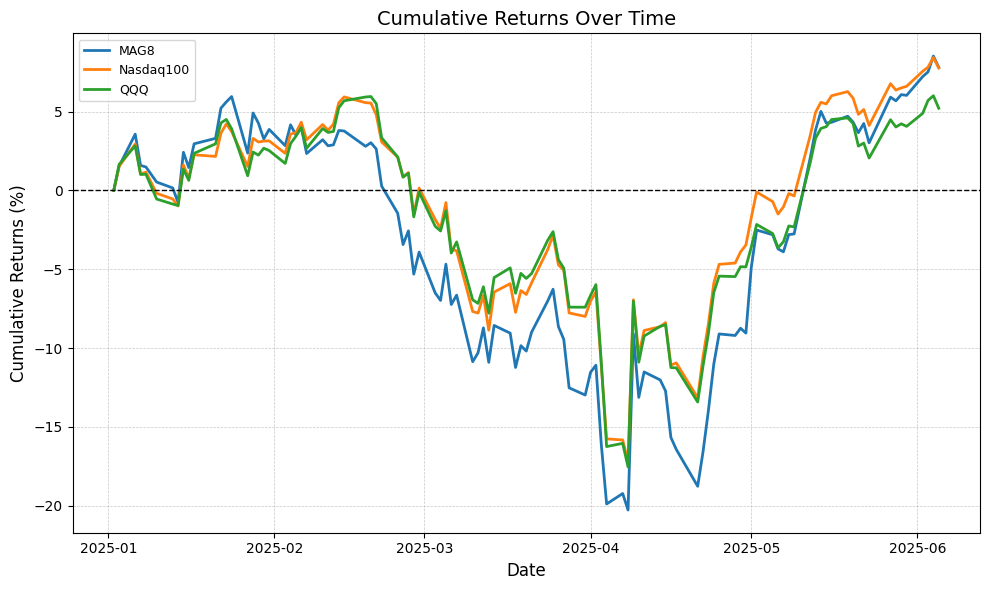

In [17]:
from analytics.performance import performance_analytics as perf

portfolio_short_names = ["Nasdaq100","MAG8","QQQ"]
portfolio_market_data = database.get_portfolio_market_data(session, engine, start_date, end_date, portfolio_short_names)
portfolio_asset_returns = perf.calculate_portfolio_constituent_returns(portfolio_market_data, "adj_close")["returns"]
portfolio_asset_weights = perf.calculate_portfolio_constituent_weights(portfolio_market_data, "adj_close", "market_weighted")
portfolio_return = (portfolio_asset_returns * portfolio_asset_weights).T.groupby(level=0).sum().T

portfolio_total_return = portfolio_asset_returns * portfolio_asset_weights
perf.plot_cumulative_returns(portfolio_total_return.T.groupby(level=0).sum().T)

#### Equal Weighted

Calculate portfolio returns and weights using the equal weighting methodology.<br>
We also observe that the Mag8 underperforms QQQ which underperforms Nasdaq100</br>

👉 Equal-weighting reveals that performance is heavily concentration-driven. The mega-cap names look weaker without their cap-weight boost, and the broader Nasdaq-100 benefits more from equal exposure

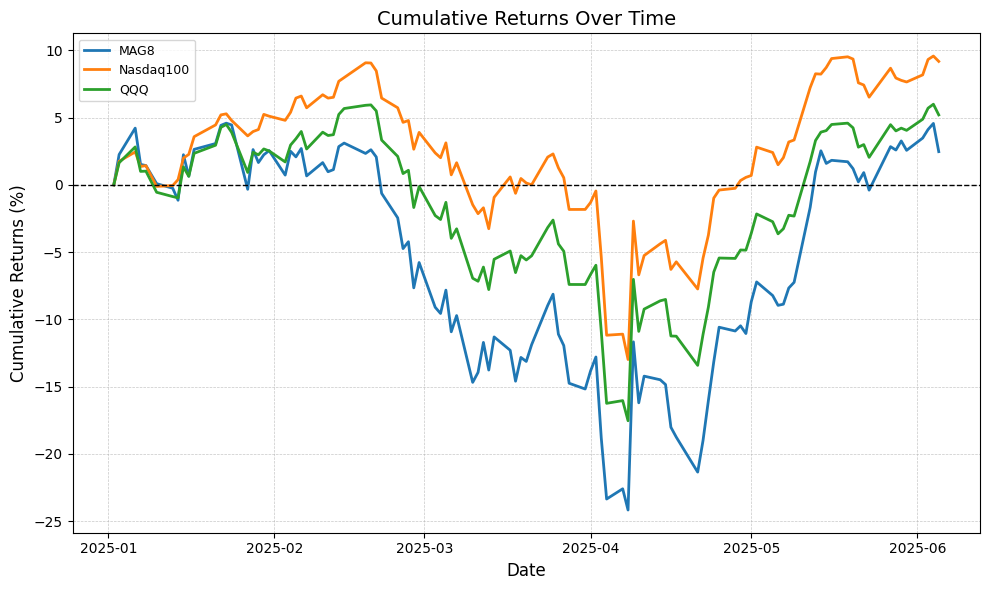

In [18]:
portfolio_short_names = ["Nasdaq100","MAG8","QQQ"]
portfolio_market_data = database.get_portfolio_market_data(session, engine, start_date, end_date, portfolio_short_names)
portfolio_asset_returns = perf.calculate_portfolio_constituent_returns(portfolio_market_data, "adj_close")["returns"]
portfolio_asset_weights = perf.calculate_portfolio_constituent_weights(portfolio_market_data, "adj_close", "equal_weighted")
portfolio_return = (portfolio_asset_returns * portfolio_asset_weights).T.groupby(level=0).sum().T

portfolio_total_return = portfolio_asset_returns * portfolio_asset_weights
perf.plot_cumulative_returns(portfolio_total_return.T.groupby(level=0).sum().T)

#### Mixed Weighted

Calculate portfolio returns and weights for MAG8 using equal weighting and for Nasdaq100 and QQQ using market weighting. This approach provides a hybrid perspective on portfolio performance.

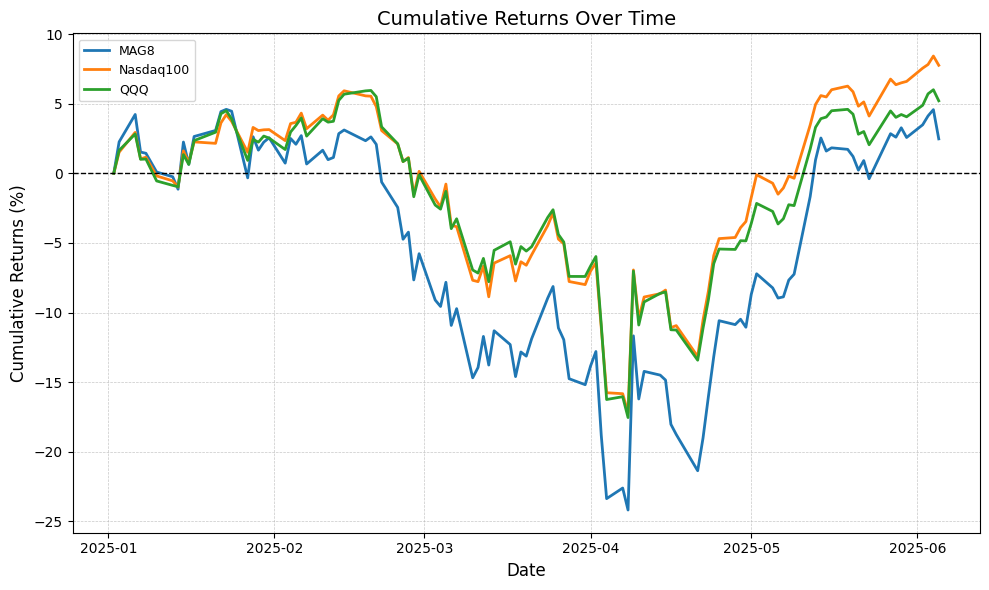

In [19]:
portfolio_short_names = ["Nasdaq100","MAG8","QQQ"]
portfolio_market_data = database.get_portfolio_market_data(session, engine, start_date, end_date, portfolio_short_names)
portfolio_asset_returns = perf.calculate_portfolio_constituent_returns(portfolio_market_data, "adj_close")["returns"]
portfolio_asset_weights = perf.calculate_portfolio_constituent_weights(portfolio_market_data, "adj_close", "market_weighted",portfolio_specific_weights={
        "MAG8": "equal_weighted"
    })
portfolio_return = (portfolio_asset_returns * portfolio_asset_weights).T.groupby(level=0).sum().T

portfolio_total_return = portfolio_asset_returns * portfolio_asset_weights
perf.plot_cumulative_returns(portfolio_total_return.T.groupby(level=0).sum().T)

## 8. Portfolio Risk Analysis

The Mag8 portfolio shows the highest risk, with both historical and parametric VaR values significantly more negative than QQQ and Nasdaq100. QQQ sits in the middle, suggesting more concentration risk than the broader Nasdaq100, which has the lowest risk due to greater diversification. Parametric VaR is consistently more conservative than historical VaR across all three, possibly reflecting volatility clustering or heavier tails in return distributions. This difference is especially noticeable in Mag8, where parametric VaR nearly doubles historical VaR.

In [20]:
# Calculate Portfolio Risk
from analytics.risk import risk_analytics as risk
max_date_index = portfolio_asset_weights.index.max()
df_portfolio_var = []

for PortfolioShortName in portfolio_short_names:
    portfolio_returns = portfolio_asset_returns[PortfolioShortName]
    portfolio_weights = portfolio_asset_weights[PortfolioShortName]
    portfolio_latest_weights = portfolio_asset_weights[max_date_index:max_date_index][PortfolioShortName]

    obj_risk = risk.PortfolioVaR(portfolio_asset_returns,
                                 portfolio_latest_weights,
                                 PortfolioShortName,
                                 lookback_days=24,
                                 horizon_days=1,
                                 confidence_interval=0.99)

    var_result = obj_risk.calculate_var()
    df_var = pd.DataFrame.from_dict(var_result, orient="columns")
    df_portfolio_var.append(df_var)

df_combined_var = pd.concat(df_portfolio_var, keys=portfolio_short_names, ignore_index=False)
df_combined_var

AsOfDate PortfolioShortName                MetricName  \
Nasdaq100 0 2025-06-05          Nasdaq100  1-Day 99% Historical VaR   
          1 2025-06-05          Nasdaq100  1-Day 99% Parametric VaR   
MAG8      0 2025-06-05               MAG8  1-Day 99% Historical VaR   
          1 2025-06-05               MAG8  1-Day 99% Parametric VaR   
QQQ       0 2025-06-05                QQQ  1-Day 99% Historical VaR   
          1 2025-06-05                QQQ  1-Day 99% Parametric VaR   

            MetricType MetricLevel  MetricValue  
Nasdaq100 0       Risk   Portfolio    -0.009336  
          1       Risk   Portfolio    -0.021692  
MAG8      0       Risk   Portfolio    -0.018614  
          1       Risk   Portfolio    -0.034346  
QQQ       0       Risk   Portfolio    -0.012840  
          1       Risk   Portfolio    -0.023608